In [1]:
""" Import Necessary Packages """

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np                     
import matplotlib.pyplot as plt        
%matplotlib inline

<h1> Synthetic Dataset Generation

In [2]:
""" Create Blobs synthetic data set """
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 5000, centers = [[1,5], [5,1], [0,0], [6,6]])
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]
X = pd.DataFrame(X, columns = ['X1', 'X2'])
y = pd.Series(y)

In [3]:
""" Check the contents of the set """
print('%d Data Points and %d Features' % (X.shape))
print('%d Positives out of %d' % (sum(y), len(y)))

5000 Data Points and 2 Features
2500 Positives out of 5000


In [4]:
""" Save original labels for later use"""
y_orig = y.copy()

""" Unlabel certain sample of positive instances """
hidden_size = 2000
y.loc[np.random.choice(y[y == 1].index, replace = False, size = hidden_size)] = 0

In [5]:
""" Check the new labels distribution """ 
print('%d Positives out of %d' % (sum(y), len(y)))

500 Positives out of 5000


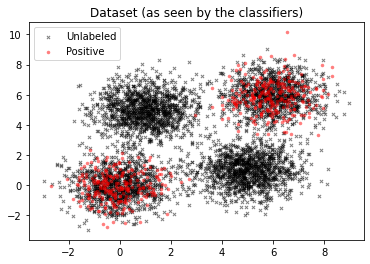

In [6]:
""" Plot the data set, as the models will see it """

plt.scatter(
    X[y==0].X1, X[y==0].X2, 
    c='k', marker='x', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)

plt.scatter(
    X[y==1].X1, X[y==1].X2, 
    c='r', marker='.', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Dataset (as seen by the classifiers)')
plt.show()

<h1> Standard Classifier Model

In [31]:
""" Random Forest Classifier Model """

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 100,  # Use 100 trees
    n_jobs = -1 # Use all CPU cores
)

rf.fit(X, y)

""" Store the scores assigned by this approach """

results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels that model sees
    'output_std' : rf.predict_proba(X)[:,1]   # Probability Scores
}, columns = ['truth', 'label', 'output_std'])

y_comp=[]
for i in range(len(results['truth'])):
    if results['output_std'][i] > 0.15:
        y_comp.append(1)
    else:
        y_comp.append(0)

        
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve



# Calculate accuracy
accuracy = accuracy_score(results['truth'], y_comp)

# Calculate F1 score
f1 = f1_score(results['truth'], y_comp)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(results['truth'], y_comp)

# Get ROC curve values
#fpr, tpr, thresholds = roc_curve(actual_label, f_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)



Accuracy: 0.6464
F1 score: 0.4556650246305418
AUC-ROC score: 0.6464


In [33]:
type(y)
type(X)
len(results['truth'])
results['output_std'][0]
results['truth']


0       1
1       0
2       0
3       1
4       1
       ..
4995    1
4996    0
4997    1
4998    0
4999    0
Name: truth, Length: 5000, dtype: int32

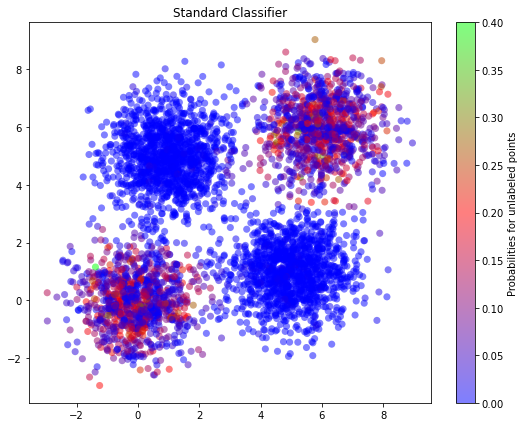

In [8]:
""" Visualize Standard Classifier approach's results """

plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].X1, X[y==0].X2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'brg'
)
plt.colorbar(label='Probabilities for unlabeled points')
plt.title('Standard Classifier')
plt.show()

<h1> PU Bagging Model

* Create a training set by combining all positive data points with a 
random sample from the unlabeled points, with replacement.

* Build a classifier from this "bootstrap" sample, treating positive and unlabeled data points as positives and negatives, respectively.

* Apply the classifier to whatever unlabeled data points were not included in the random sample – hereafter called OOB ("out of bag") points – and record their scores.

* Repeat the three steps above many times and finally assign to each point the average of the OOB scores it has received.

In [35]:
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(random_state=42)

""" Indices of positive and unlabeled data points """
iP = y[y > 0].index
iU = y[y <= 0].index

""" For each data point, keep track of how many times it has been OOB """
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

n_estimators = 1000
for _ in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # Find the OOB data points for this round
    i_oob = list(set(iU) - set(ib))

    # Get the training data (ALL positives and the bootstrap sample of unlabeled points) and build the tree
    Xb = pd.concat([X[y > 0],X.loc[ib]])
    yb = pd.concat([y[y > 0], y.loc[ib]])
    estimator.fit(Xb, yb)
    
    # Record the OOB scores from this round
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

""" Finally, store the probabilities assigned by this approach """
results['output_bag'] = sum_oob / num_oob

In [41]:
y2_comp=[]
for i in range(len(results['truth'])):
    if results['output_bag'][i] > 0.40:
        y2_comp.append(1)
    else:
        y2_comp.append(0)

# Calculate accuracy
accuracy = accuracy_score(results['truth'], y2_comp)

# Calculate F1 score
f1 = f1_score(results['truth'], y2_comp)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(results['truth'], y2_comp)

# Get ROC curve values
#fpr, tpr, thresholds = roc_curve(actual_label, f_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)
        


Accuracy: 0.8718
F1 score: 0.855467869222097
AUC-ROC score: 0.8718


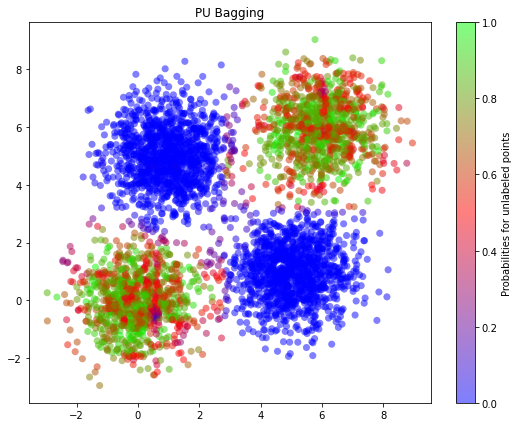

In [13]:
""" Visualize PU Bagging Classifier approach's results """
plt.scatter(
    X[y==0].X1, X[y==0].X2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'brg'
)
plt.colorbar(label='Probabilities for unlabeled points')
plt.title('PU Bagging')
plt.show()

<h1> Two-Step Strategy Model

* Identify a subset of the unlabeled data points that can be confidently labeled as negatives. ("reliable negatives.")
* Use the positive and negative data points to train a standard classifier and apply it to the remaining unlabeled points.


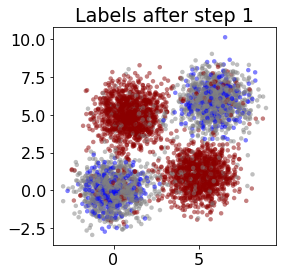

Step 1 labeled 0 new positives and 2444 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 253 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 60 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 50 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 44 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 31 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 26 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 22 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 23 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 24 new negatives.
Doing step 2... 

In [43]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the scores from before
pred = rf.predict_proba(X)[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Show the results of step 1
plt.rcParams['figure.figsize'] = 4,4
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.X1, X.X2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the Probabilities assigned by this approach    
results['output_stp'] = pred

In [62]:
y3_comp=[]
for i in range(len(results['truth'])):
    if results['output_stp'][i] > 0.03:
        y3_comp.append(1)
    else:
        y3_comp.append(0)

# Calculate accuracy
accuracy = accuracy_score(results['truth'], y3_comp)

# Calculate F1 score
f1 = f1_score(results['truth'], y3_comp)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(results['truth'], y3_comp)

# Get ROC curve values
#fpr, tpr, thresholds = roc_curve(actual_label, f_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)

Accuracy: 0.8592
F1 score: 0.8380864765409384
AUC-ROC score: 0.8592000000000001


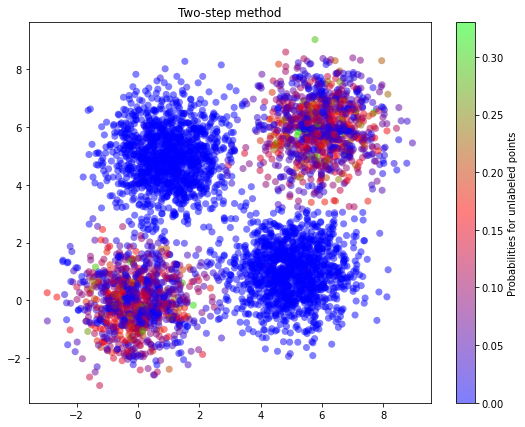

In [19]:
# Visualize this approach's final results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].X1, X[y==0].X2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'brg'
)
plt.colorbar(label='Probabilities for unlabeled points')
plt.title('Two-step method')
plt.show()

<h1> Average of 3 Approaches

In [63]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_std', 'output_bag', 'output_stp'
]].mean(axis = 1)

In [65]:
y4_comp=[]
for i in range(len(results['truth'])):
    if results['output_all'][i] > 0.1:
        y4_comp.append(1)
    else:
        y4_comp.append(0)

# Calculate accuracy
accuracy = accuracy_score(results['truth'], y4_comp)

# Calculate F1 score
f1 = f1_score(results['truth'], y4_comp)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(results['truth'], y4_comp)

# Get ROC curve values
#fpr, tpr, thresholds = roc_curve(actual_label, f_pred)

print("Accuracy:", accuracy)
print("F1 score:", f1)
print("AUC-ROC score:", auc_roc)

Accuracy: 0.984
F1 score: 0.9840510366826155
AUC-ROC score: 0.9840000000000001


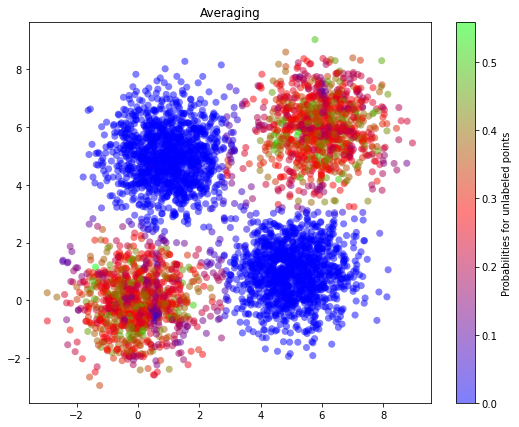

In [21]:
# Visualize average scores
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].X1, X[y==0].X2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'brg'
)
plt.colorbar(label='Probabilities for unlabeled points')
plt.title('Averaging')
plt.show()